# causalBootstrapping: Tutorial 02

A series of tutorials demonstrating the use of the causalBootstrapping library.

### Frontdoor

This tutorial mainly focuses on illustrating the use of frontdoor causal bootstrapping interfaces: `frontdoor_simple()` and `frontdoor_simu()`.

In [1]:
from causalbootstrapping import workflows
from causalbootstrapping.distEst_lib import MultivarContiDistributionEstimator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import classification_report

plt.rcParams['font.family'] = 'Calibri'
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
plt.rcParams["axes.titlesize"] = 16

def linear_decision_boundary(clf, xlim):
    weight = clf.coef_[0]
    bias = clf.intercept_[0]
    k = -weight[0] / weight[1]
    b = -bias / weight[1]
    x = np.linspace(xlim[0], xlim[1], 100)
    decison_boundary = k * x + b
    return decison_boundary

def plot_boundary(ax, X, Y, db, xlim, ylim, plot_title):
    handles = []
    scatter = ax.scatter(x= X[:,0], y = X[:,1], c = Y, s = 10, alpha = 0.4, cmap='coolwarm')
    handles_scatter, labels_scatter = scatter.legend_elements(prop="colors")
    handles += handles_scatter
    ax.set_xlim(xlim[0],xlim[1])
    ax.set_ylim(ylim[0],ylim[1])
    x_ = np.linspace(xlim[0], xlim[1], 100)
    
    true_b = ax.plot([0, 0], [-6, 6], 'k', linewidth=4, label="True boundary")
    confounder = ax.plot([-6,6], [0,0], 'orange', linewidth = 4, label = "Confounder boundary")
    clf_b = ax.plot(x_, db, 'r', linewidth = 4, label= 'Classifier Decision')
    handles += [true_b[0], confounder[0], clf_b[0]]
    ax.set_title(plot_title)
    ax.set_xlabel(r"$X_1$")
    ax.set_ylabel(r"$X_2$")
    return ax, handles

#### Usage example: frontdoor_simple()

In [2]:
# Read demo data
testdata_dir = "../test_data/frontdoor_discY_contZ_contX_discU/"
X_train = pd.read_csv(testdata_dir + "X_train.csv").values
Y_train = pd.read_csv(testdata_dir + "Y_train.csv").values
Z_train = pd.read_csv(testdata_dir + "Z_train.csv").values

In [3]:
# Re-formulate the data
cause_data = {"Y'": Y_train}
mediator_data = {"Z": Z_train}
effect_data = {"X": X_train}

In [4]:
# Estimate the desired distributions
n_bins_yz = [0,20]
n_bins_y = [0]
joint_yz_data = np.concatenate((Y_train.reshape(-1,1), Z_train), axis = 1)

dist_estimator_yz = MultivarContiDistributionEstimator(data_fit=joint_yz_data)
pdf_yz = dist_estimator_yz.fit_histogram(n_bins = n_bins_yz)
dist_estimator_y = MultivarContiDistributionEstimator(data_fit=Y_train)
pdf_y = dist_estimator_y.fit_histogram(n_bins = n_bins_y)

In [5]:
# Construct the distribution mapping dict
dist_map = {"intv_Y,Z": lambda intv_Y, Z: pdf_yz([intv_Y,Z]),
            "Y',Z": lambda Y_prime, Z: pdf_yz([Y_prime,Z]),
            "intv_Y": lambda intv_Y: pdf_y(intv_Y),
            "Y'": lambda Y_prime: pdf_y(Y_prime)}

In [6]:
# bootstrap the dataset given the frontdoor scenario
cb_data = workflows.frontdoor_intv(cause_data, 
                                   mediator_data, 
                                   effect_data, 
                                   dist_map, 
                                   cause_intv_name_map = {"Y": "intv_Y"})

In [7]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=3)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=3)
clf_cb.fit(cb_data['X'], cb_data['intv_Y'].reshape(-1))

## compare their performance on un-confounded test set
X_test = pd.read_csv(testdata_dir +  "X_test.csv").values
Y_test = pd.read_csv(testdata_dir +  "Y_test.csv").values

y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.63      0.80      0.71       386
           2       0.85      0.71      0.77       614

    accuracy                           0.74      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.77      0.74      0.75      1000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       386
           2       0.89      0.82      0.85       614

    accuracy                           0.83      1000
   macro avg       0.82      0.83      0.82      1000
weighted avg       0.83      0.83      0.83      1000



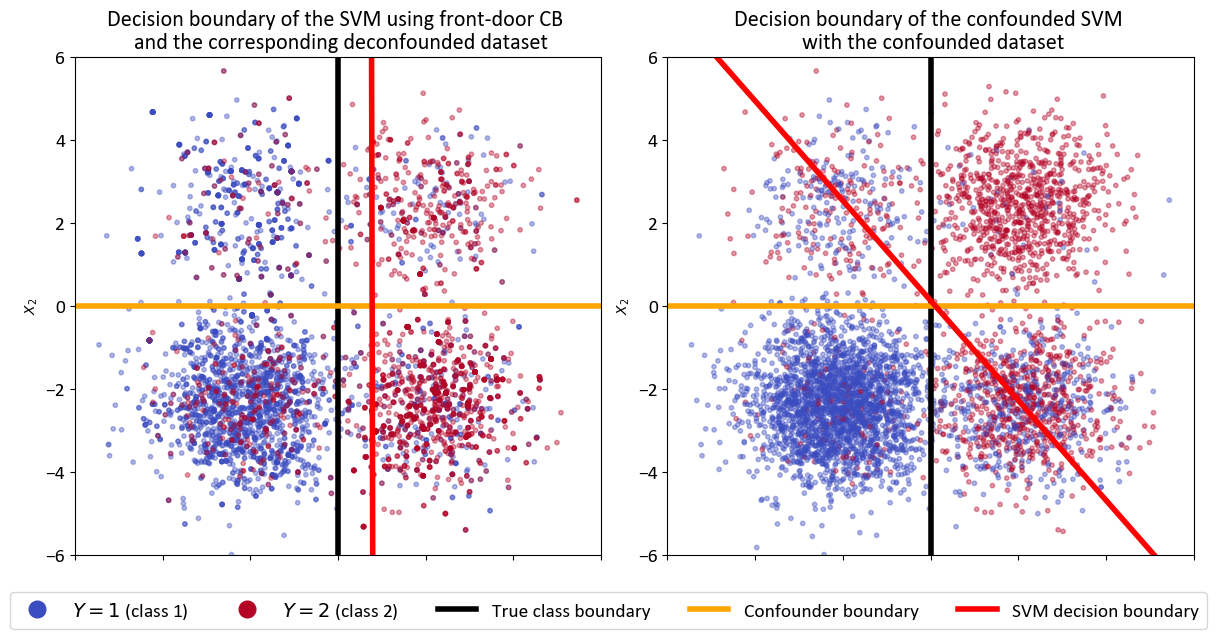

In [8]:
# Compare models' decision boundaries
decision_boundary_deconf_cb = linear_decision_boundary(clf = clf_cb, xlim = [-4,4])
decision_boundary_conf = linear_decision_boundary(clf = clf_conf, xlim = [-4,4])

fig, axes = plt.subplots(1,2, figsize = (12,7))
axes[0], _ = plot_boundary(axes[0], cb_data['X'], cb_data['intv_Y'], 
                        decision_boundary_deconf_cb, [-6,6], [-6,6], 'Decision boundary of the SVM using front-door CB \n and the corresponding deconfounded dataset')
axes[1], handles = plot_boundary(axes[1], X_train, Y_train, 
                        decision_boundary_conf, [-6,6], [-6,6], 'Decision boundary of the confounded SVM \n with the confounded dataset')
axes[0].tick_params(labelbottom=False)
axes[0].set_xlabel('')  
axes[1].tick_params(labelbottom=False)
axes[1].set_xlabel('')  
labels = [r'$Y=1$ (class 1)', r'$Y=2$ (class 2)',
          'True class boundary', 'Confounder boundary', 'SVM decision boundary']
legend =fig.legend(handles=handles,
                   labels=labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=5,
                   markerscale=2)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

#### Usage example: frontdoor_simu()

In [9]:
# Set simulated interventions and bootstrap the data
n_sample = 2000
cb_data_cf_intv1 = workflows.frontdoor_cf(cause_data = cause_data, 
                                          mediator_data = mediator_data, 
                                          effect_data = effect_data,
                                          dist_map = dist_map, 
                                          intv_dict = {"intv_Y": 1}, 
                                          n_sample = n_sample)
cb_data_cf_intv2 = workflows.frontdoor_cf(cause_data = cause_data, 
                                          mediator_data = mediator_data, 
                                          effect_data = effect_data,
                                          dist_map = dist_map, 
                                          intv_dict = {"intv_Y": 2}, 
                                          n_sample = n_sample)
cb_data_cf = {}
for key in cb_data_cf_intv1.keys():
    cb_data_cf[key] = np.vstack((cb_data_cf_intv1[key], cb_data_cf_intv2[key]))

In [10]:
## Train two linear support vector machines using confounded and de-confounded datasets
clf_conf = svm.SVC(kernel = 'linear', C=5)
clf_conf.fit(X_train, Y_train.reshape(-1))

clf_cb = svm.SVC(kernel = 'linear', C=5)
clf_cb.fit(cb_data_cf['X'], cb_data_cf['intv_Y'].reshape(-1))

## compare their performance on un-confounded test set
y_pred_conf = clf_conf.predict(X_test)
print("Report of confonded model:")
print(classification_report(Y_test, y_pred_conf))

y_pred_deconf = clf_cb.predict(X_test)
print("Report of de-confonded model:")
print(classification_report(Y_test, y_pred_deconf))

Report of confonded model:
              precision    recall  f1-score   support

           1       0.63      0.80      0.71       386
           2       0.85      0.71      0.77       614

    accuracy                           0.74      1000
   macro avg       0.74      0.75      0.74      1000
weighted avg       0.77      0.74      0.75      1000

Report of de-confonded model:
              precision    recall  f1-score   support

           1       0.77      0.82      0.80       386
           2       0.88      0.85      0.87       614

    accuracy                           0.84      1000
   macro avg       0.83      0.84      0.83      1000
weighted avg       0.84      0.84      0.84      1000



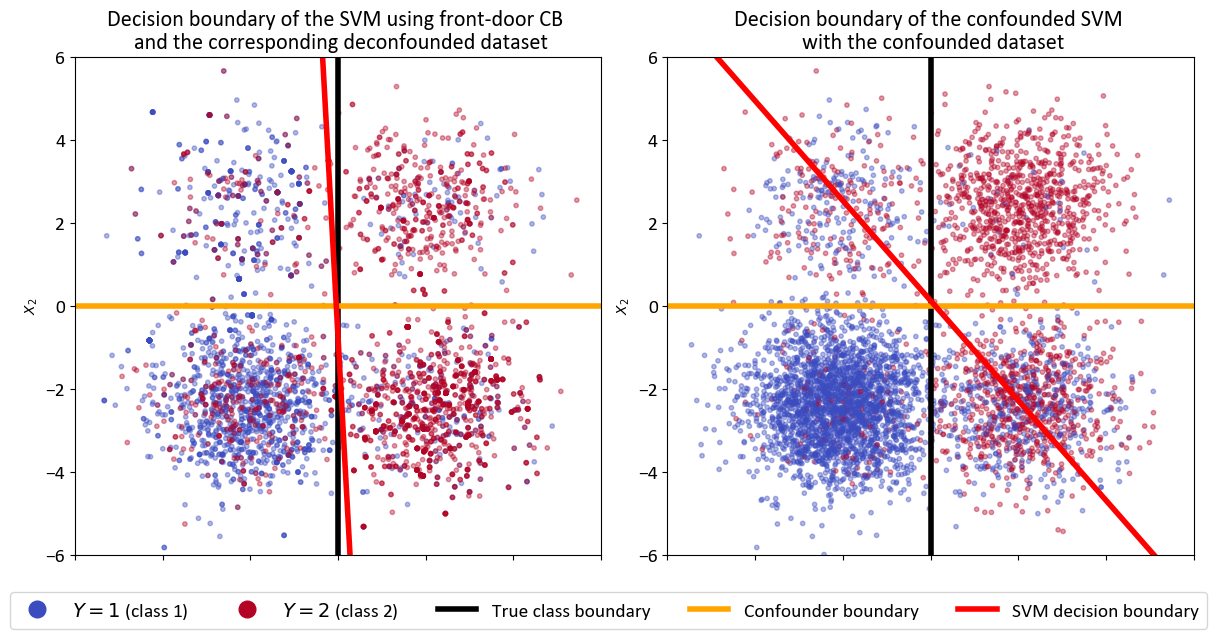

In [11]:
# Compare models' decision boundaries
decision_boundary_deconf_cb = linear_decision_boundary(clf = clf_cb, xlim = [-4,4])
decision_boundary_conf = linear_decision_boundary(clf = clf_conf, xlim = [-4,4])

fig, axes = plt.subplots(1,2, figsize = (12,7))
axes[0], _ = plot_boundary(axes[0], cb_data_cf['X'], cb_data_cf['intv_Y'], 
                        decision_boundary_deconf_cb, [-6,6], [-6,6], 'Decision boundary of the SVM using front-door CB \n and the corresponding deconfounded dataset')
axes[1], handles = plot_boundary(axes[1], X_train, Y_train, 
                        decision_boundary_conf, [-6,6], [-6,6], 'Decision boundary of the confounded SVM \n with the confounded dataset')
axes[0].tick_params(labelbottom=False)
axes[0].set_xlabel('')  
axes[1].tick_params(labelbottom=False)
axes[1].set_xlabel('')  
labels = [r'$Y=1$ (class 1)', r'$Y=2$ (class 2)',
          'True class boundary', 'Confounder boundary', 'SVM decision boundary']
legend =fig.legend(handles=handles,
                   labels=labels,
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.08),
                   ncol=5,
                   markerscale=2)
for handle in legend.legend_handles:
    handle.set_alpha(1.0)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()